- To be used for inference purpose 

    - Inference for momentum and pressure

gputrue=False
# Use CPU
if gputrue==True:
    
    with tf.device('/CPU:0'):
        cpu_tensor = tf.constant(1.0)
else:
# Use GPU (if available)
    with tf.device('/GPU:0'):
        gpu_tensor = tf.constant(1.0)

In [1]:
# Function to get CPU memory usage

def get_cpu_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss  # in bytes

# Function to get GPU memory usage using nvidia-smi
def get_gpu_memory_usage():
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ])
    return int(result.split()[0])  # in MB



import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')


In [2]:
import os,sys
current_dir = os.getcwd()    # Get the current directory. 
sys.path.append(current_dir) # Append to path 
fn2=os.path.join(current_dir,'..','SourceCode')
sys.path.append(fn2)         # Add the path to the folder containing imports.py


import tensorflow as tf
from tensorflow.python.client import device_lib
import psutil
import os
import subprocess
import imports_kpn as kpn


# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')

#Hide CPU from visible devices
tf.config.list_physical_devices('GPU')
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'




# Restrict TensorFlow to only use the GPU
# Function to set CPU as the visible device
def use_cpu():
    tf.config.set_visible_devices([], 'GPU') #Hide GPU from visible devices

# Function to set GPU as the visible device
def use_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.set_visible_devices(gpus[0], 'GPU')
        except RuntimeError as e:
            print(e)

c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\py310gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_gpu()

In [4]:
#device_lib.list_local_devices()

In [5]:

 # For ANN, For lstm use imports_kpn



        
        
# import tensorflow as tf  # version 2.6.0
import joblib #Version: 1.2.0
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error #scikit-learn              1.3.0 
import numpy
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 26})


def scale_3D_inference(data_test_features,normalizer_test):
    
    # Step: Reshape Test dataset to 2D
    samples_test, timesteps_test, features_test = data_test_features.shape
    data_test_features = data_test_features.reshape(-1, features_test) 
    
    # Step: Scale features in test dataset         
    norm_test_features=normalizer_test.transform(data_test_features)
        
    #print(normalizer_test.data_max_)
    #print(normalizer_test.data_min_)
    
    # Step: Reshape back to 3D
    norm_test_features = norm_test_features.reshape(samples_test, timesteps_test, features_test)
    
    return norm_test_features


    - Give path locations to test data

In [6]:
momentum=True
pressure=False
allsamples=False

In [7]:
if momentum==True:
    dirFile='../Models/LSTM_HAM'  #ML model for momentum
 
    dirFile_result='../Results'
    # kpn.create_directory_if_not_exists(dirFile_result) 
     
    filename_4_scalingfunction = dirFile + "/Scaling.save"
    
elif pressure==True:
    dirFile='../Models/LSTM_HAM_Pressure'
    # kpn.create_directory_if_not_exists(dirFile)
   
    dirFile_result='../Results_Pressure'
    # kpn.create_directory_if_not_exists(dirFile_result)  
    
    filename_4_scalingfunction = dirFile + "/Scaling.save"
else:
    print('Please choose either momentum or pressure as true')
    


In [8]:
# Inference

                  
import time
start = time.process_time()

#Load model from path's location (momentum or pressure)
model=tf.keras.models.load_model(dirFile+'/best_model.h5')

#Load unseen test dataset and scale it for inference.  
    # CHECK : Test FEATURES data shape: num_samples (either 1 or all samples) x 3 x num_modes (num_modes=18 for momentum and 10 for pressure). 
    # Load scaling function for either momentum and pressure
    
    
# Data path for pre-processed data
datapath ="../Data/Coefficient/"

# Data path for modeled data
modelpathbase = "../Data/Coefficient/"

# Data from measurement data
A = kpn.np.load(datapath + 'A.npy') #Features for the momentum
MomentumRes = kpn.np.load(datapath + 'MomentumRes.npy') #label for the momentum

#Split of training and validation data.
xtrain,xtest=kpn.split_timeseries_3D(A,nfrac=0.8)

print(xtrain.shape,xtest.shape)

ytrain,ytest=kpn.split_timeseries_3D(MomentumRes,nfrac=0.8)

if allsamples==True: 
    test_data=xtrain # Load features dataset #[0,:,:].reshape(1,xtrain.shape[1],xtrain.shape[2])
else:
    test_data=xtrain[0,:,:].reshape(1,xtrain.shape[1],xtrain.shape[2])
    
print(f"CPU Memory usage before start: {get_cpu_memory_usage() / (1024 ** 2):.2f} MB")
print(f"GPU Memory usage before start: {get_gpu_memory_usage()} MB")

timely=[]
start2 = time.process_time()
num=1000
for i in range(num):   
    
    normalizer=joblib.load(filename_4_scalingfunction)

    norm_test_features=scale_3D_inference(test_data,normalizer) # data_test_features



    #Predict the residual using the model
    addcorrection=model.predict(norm_test_features) #addcorrection shape : num_samples x num_modes

    print(time.process_time() - start)
    print("Computational time no loading, s", time.process_time() - start2)
timely.append( time.process_time() - start2)      
# #Plot the residual

# Check memory usage and time
print(f"Mean Time: s, {(time.process_time() - start)/num}")
print(f"CPU Memory usage: {get_cpu_memory_usage() / (1024 ** 2):.2f} MB")
print(f"GPU Memory usage: {get_gpu_memory_usage()} MB")


print(norm_test_features.shape)



(80, 3, 18) (20, 3, 18)
CPU Memory usage before start: 1063.26 MB
GPU Memory usage before start: 5739 MB
1/1 [==============================] - 3s 3s/step
0.9375
Computational time no loading, s 0.453125
1/1 [==============================] - 0s 16ms/step
0.9375
Computational time no loading, s 0.453125
1/1 [==============================] - 0s 19ms/step
0.9375
Computational time no loading, s 0.453125
1/1 [==============================] - 0s 14ms/step
0.953125
Computational time no loading, s 0.46875
1/1 [==============================] - 0s 16ms/step
0.953125
Computational time no loading, s 0.46875
1/1 [==============================] - 0s 18ms/step
0.96875
Computational time no loading, s 0.484375
1/1 [==============================] - 0s 20ms/step
0.984375
Computational time no loading, s 0.5
1/1 [==============================] - 0s 13ms/step
0.984375
Computational time no loading, s 0.5
1/1 [==============================] - 0s 24ms/step
0.984375
Computational time no loading, 

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([8.65625, 8.75625, 8.85625, 8.95625, 9.05625, 9.15625, 9.25625,
        9.35625, 9.45625, 9.55625, 9.65625]),
 <BarContainer object of 10 artists>)

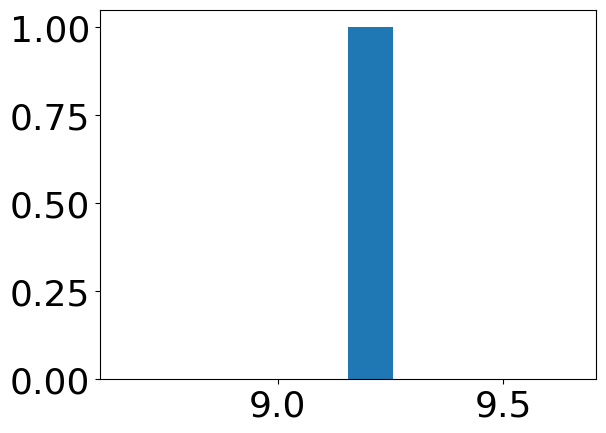

In [9]:
kpn.plt.hist(timely)

In [10]:
kpn.np.array(timely).mean()

9.15625

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'\\)))

for i in range(addcorrection.shape[1]):
    plt.figure(figsize=(20,12))
   
    plt.plot(addcorrection[:,i],label='ML predicted')
    
    plt.title('Comparison plot')
    
    plt.legend()
    
    filename = f'Comparison plot_{i}.png'
    
    plt.savefig(os.path.abspath(dirFile_result+'/'+filename), dpi = 200)
    
    plt.show()  